In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tqdm
from tqdm import tqdm
import nltk
import warnings
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import wordcloud
from wordcloud import WordCloud
import datetime

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.chdir("/content/drive/My Drive/sentiment analysis")

## Loading the dataset

In [5]:
data=pd.read_csv("Amazon_Product_Dataset.csv")
print(data.shape)
data

(34660, 21)


,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34655,AVpfiBlyLJeJML43-4Tp,NaN,B006GWO5WK,Amazon,"Computers/Tablets & Networking,Tablet & eBook ...",newamazonkindlefirehd9wpowerfastadaptercharger...,"Amazon Digital Services, Inc",2012-09-18T00:00:00Z,NaN,2015-08-29T00:00:00Z,NaN,NaN,NaN,NaN,3.0,http://www.amazon.com/Amazon-PowerFast-Adapter...,This is not appreciably faster than any other ...,Not appreciably faster than any other 1.8A cha...,NaN,NaN,Kris
34656,AVpfiBlyLJeJML43-4Tp,NaN,B006GWO5WK,Amazon,"Computers/Tablets & Networking,Tablet & eBook ...",newamazonkindlefirehd9wpowerfastadaptercharger...,"Amazon Digital Services, Inc",2012-11-21T00:00:00Z,NaN,2015-09-02T00:00:00Z,NaN,NaN,NaN,NaN,1.0,http://www.amazon.com/Amazon-PowerFast-Adapter...,Amazon should include this charger with the Ki...,Should be included,NaN,NaN,Jonathan Stewart
34657,AVpfiBlyLJeJML43-4Tp,NaN,B006GWO5WK,Amazon,"Computers/Tablets & Networking,Tablet & eBook ...",newamazonkindlefirehd9wpowerfastadaptercharger...,"Amazon Digital Services, Inc",2012-10-19T00:00:00Z,NaN,2015-09-04T00:00:00Z,NaN,NaN,NaN,NaN,1.0,http://www.amazon.com/Amazon-PowerFast-Adapter...,Love my Kindle Fire but I am really disappoint...,Disappointing Charger,NaN,NaN,J Lawson
34658,AVpfiBlyLJeJML43-4Tp,NaN,B006GWO5WK,Amazon,"Computers/Tablets & Networking,Tablet & eBook ...",newamazonkindlefirehd9wpowerfastadaptercharger...,"Am

## Aim: This is the datset of amazon product reviews. A number of features are available for a particular product id. Our aim is to predict the sentiment of a product review using these featues

In [ ]:
print(data.columns)

Index(['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer',
       'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.userCity',
       'reviews.userProvince', 'reviews.username'],
      dtype='object')


**DATA OVERVIEW**

The data set contains 21 columns

1. Product id

2. Name of the product

3. asins :amazon standard identification number
4. brand : Amazon sub brands
5. categories which the product belongs to
6. keys
7. manufacturer of the product
8. reviews.date
9. reviews.dateAdded- The data which the review is addded
10. reviews.dateSeen
11. reviews.didPurchase
12. reviews.doRecommend- if the customer recommends this product or not
13. reviews.id- id of each review
14. reviews.numHelpful- Number of users who find the review helpful
15. reviews.rating- Rating of the review
16. reviews.sourceURLs
17. reviews.text- The reviews
18. reviews.title - the title of the review
19. reviews.userCity- The city of the user
20. reviews.userProvince
21. reviews.username' - User name 



Let' check for the no of rows without any data for each feature

In [ ]:
data.isna().sum()

id                          0
name                     6760
asins                       2
brand                       0
categories                  0
keys                        0
manufacturer                0
reviews.date               39
reviews.dateAdded       10621
reviews.dateSeen            0
reviews.didPurchase     34659
reviews.doRecommend       594
reviews.id              34659
reviews.numHelpful        529
reviews.rating             33
reviews.sourceURLs          0
reviews.text                1
reviews.title               5
reviews.userCity        34660
reviews.userProvince    34660
reviews.username            2
dtype: int64

**OBSERVATION:** From this we see that the features like name, reviews date added, reviews did purcahse, reviews.id, reviews. user city, user province has too many missing values. Also, we can say that, these features will not play a major role in predicting the rating pf the reviews. So we skip these features.

## Univariate Analysis

Now lets analyse the rest of the features and check what all features are uselful in predicting the sentiment of a review


The feature called asin in amazon stanadard identifiaction number. Thi clearly has no impact on predicting the rating of a review. So we discard this feature also

### Role of the features "brand"

let's see what all brands are available in this data

In [ ]:
np.unique(data["brand"].values)

array(['Amazon', 'Amazon Coco T', 'Amazon Digital Services Inc.',
       'Amazon Echo', 'Amazon Fire', 'Amazon Fire Tv'], dtype=object)

This is a categorical feature. There are six different amazon brands. Each of these brands can have different category of products

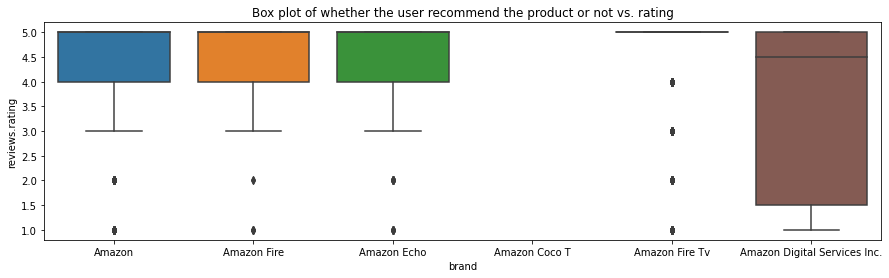

In [ ]:
fig, ax = plt.subplots(figsize=(15,4))
sns.boxplot(data["brand"],data["reviews.rating"])
plt.title("Box plot of whether the user recommend the product or not vs. rating")
plt.show()

**OBSERVATION:** This feature clearlt has no role in predicting the review. However, we can say most of the negative reviews are going for the brand- Amazon digital services. But the rating of a review cannot be determined by observing its brand. So we discard this feature also.

### Role of the feature "category"

Let's see the unique categories available in this data

In [ ]:
np.unique(data["categories"].values)

array(['Amazon Device Accessories,Kindle Store,Kindle Touch (4th Generation) Accessories,Kindle E-Reader Accessories,Covers,Kindle Touch (4th Generation) Covers',
       'Amazon Devices & Accessories,Amazon Device Accessories,Power Adapters & Cables,Kindle Store,Kindle E-Reader Accessories,Kindle Paperwhite Accessories',
       'Back To College,College Electronics,College Tvs & Home Theater,Electronics,Tvs & Home Theater,Streaming Devices,Featured Brands,Amazon Devices,Holiday Shop,Ways To Shop,TV & Home Theater,Streaming Media Players,All Streaming Media Players,TVs Entertainment,Video Games,Kindle Store,Electronics Features,Kids & Family,Fire TV',
       'Cases,Kindle Store,Amazon Device Accessories,Accessories,Tablet Accessories',
       'Categories,Streaming Media Players,Electronics',
       'Chargers & Adapters,Computers & Accessories,Tablet & E-Reader Accessories,Amazon Devices & Accessories,Fire Tablet Accessories,Electronics,Power Adapters & Cables,Cell Phones,Amazon Device Ac

There are a lot of categories available in the data. 

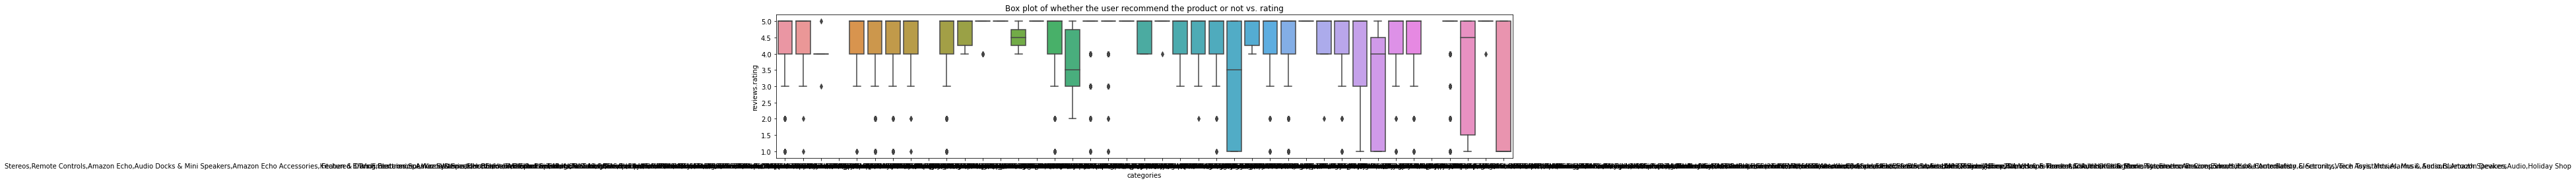

In [ ]:
fig, ax = plt.subplots(figsize=(20,4))
sns.boxplot(data["categories"],data["reviews.rating"])
plt.title("Box plot of whether the user recommend the product or not vs. rating")
plt.show()

**OBSERVATION:** There are a lot of categries avaialble. Also, this features doesnot have a major role in predicting the rating from a review. 

Clearly, the features brand, categories, keys, manufacturer ,sourceURLs does not provide any information in predicting the reviews. So we discard these features

### Role of features "reviews.date, reviews.dateAdded and reviews.dateSeen "

Here we discard the feature 'reviews.dateAdded' because it contains too many null values. We consider the "dateseen" feature because it is not having any null values. Let's print some of these dates and see how these dates are affecting the reviews

In [ ]:
ids=np.random.choice(range(data.shape[0]),10)
from datetime import datetime
for idx in ids:
  date_str= data.iloc[idx]["reviews.dateSeen"].split(",")[0]
  print(date_str)
  try:
    date=datetime.strptime(date_str, "%Y-%m-%dT%H:%M:%S.%fZ")
  except:
    date=datetime.strptime(date_str, "%Y-%m-%dT%H:%M:%SZ")
  print("DATE : ",date)
  print("DATE SEEN: ",data.iloc[idx]["reviews.dateSeen"])
  print("REVIEW: ",data.iloc[idx]["reviews.text"])

2017-04-30T00:22:00.000Z
DATE :  2017-04-30 00:22:00
DATE SEEN:  2017-04-30T00:22:00.000Z,2017-06-07T08:19:00.000Z
REVIEW:  A friend recommended I buy one. He paid $50 for his. When I saw it on sale at Best Buy for $39 I snagged one, I wish I understood the features better. I mostly use it for reading before bed. It's my first time doing so on a Kindle. Was surprised to like it so much! I live in a small trailer. It is great to an electronic library.
2017-04-30T00:09:00.000Z
DATE :  2017-04-30 00:09:00
DATE SEEN:  2017-04-30T00:09:00.000Z,2017-06-07T08:17:00.000Z
REVIEW:  the tablet is very helpful when using the internet
2017-09-28T00:00:00Z
DATE :  2017-09-28 00:00:00
DATE SEEN:  2017-09-28T00:00:00Z,2017-09-08T00:00:00Z,2017-09-12T00:00:00Z,2017-08-31T00:00:00Z,2017-08-08T00:00:00Z,2017-08-15T00:00:00Z,2017-08-01T00:00:00Z
REVIEW:  Really love this. My only issue is that there are benefits to being an amazon music service member and I don't want another provider. Still great though 

In [ ]:
dates=[]
r=[]
for idx in range(data.shape[0]):
  date_str=data.iloc[idx]["reviews.dateSeen"].split(",")[0]
  
  try:
    dates.append(datetime.strptime(date_str, "%Y-%m-%dT%H:%M:%S.%fZ"))
    r.append(data.iloc[idx]["reviews.text"])
  except:
    dates.append(datetime.strptime(date_str, "%Y-%m-%dT%H:%M:%SZ"))
    r.append(data.iloc[idx]["reviews.text"])

data["dates"]=dates

In [ ]:
min_date=np.min(dates)
indx=dates.index(min_date)
print(indx)
print("OLDEST DATE: ",min_date)
print("OLDEST REVIEW",r[indx])
max_date=np.max(dates)
indx=dates.index(max_date)
print(indx)
print("OLDEST DATE: ",max_date)
print("OLDEST REVIEW",r[indx])

2898
OLDEST DATE:  2015-01-12 00:00:00
OLDEST REVIEW I researched the purchase of a Kindle for a long time. I couldn't decide whether or not it was worth buying a dedicated e-reader. Boy am I glad I made this purchase. The downside to Amazon's online selling of Kindle 3 is that the customers don't get to see it in person. It is much better in person. This may sound stupid, but when I got my new Kindle, I thought there was a stuck-on overlay on the screen containing a diagram of the unit's buttons, etc. I actually tried to peel it off. Doh! The e-ink on this unit is THAT good. I didn't realize that I was staring at the actual display. I also didn't realize that no power is required until the display changes. (thus the great battery life) I do a lot of reading, but was facing the prospect of reading less or buying large type books because of my variable and deteriorating eyesight. The new Kindle has been a godsend. Now, I can decide the size of type I need depending on my level of fatigu

**OBSERVATION**: So we can see that the dates are ranging from 2015 to 2018. The trend of products changes vastly within this time. The products available in the year 2015 may not be available in 2018, and viceversa. So the dates helps to analyse the review. The reviews before five years might be having a totally differnt trend based on the products avaialble back then. So while prdedicting the present reviews, it is important that the algorithm knows the trends and its changes. So we need to split the data based on time. For that we need to include the date features also.

### Role of the features "reviews.doRecommend"

In [ ]:
print(np.unique(data["reviews.doRecommend"].values))
np.unique(data["reviews.doRecommend"].values).shape

[False True nan nan nan nan nan nan nan nan nan nan nan nan True nan True
 nan nan nan True nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan True nan nan nan nan nan nan nan nan nan
 True nan True nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan True
 nan True nan True nan True nan nan nan True nan True nan nan nan nan nan
 True nan nan nan True nan nan nan nan True nan True nan True nan nan nan
 nan nan nan nan nan nan nan True nan True nan nan nan True nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan True nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan True nan nan nan nan
 True nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan 

(637,)

This is also a categorical feature. We have seen that the information is not availbale for some reviews. For all other reviews, the value is True or False. Now, lets see the importance of this feature in predicting the review


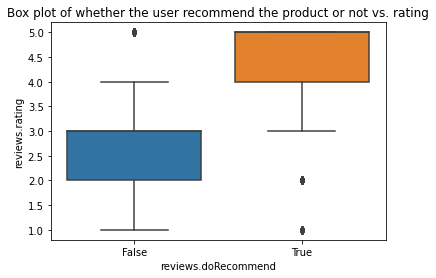

In [ ]:
sns.boxplot(data["reviews.doRecommend"],data["reviews.rating"])
plt.title("Box plot of whether the user recommend the product or not vs. rating")
plt.show()

**OBSERVATION:** From the plot we can see that, if the do.Recomend is False, then the rating is 3 or below. And if the do.Recommend is True, then the rating is above 3.
This feature is clearly helping  a lot in predicting the review. So we can consider this feature going forward. This feature can take three values- True, False or not available

### Role of the feature reviews.numHelpful in predicting the rating

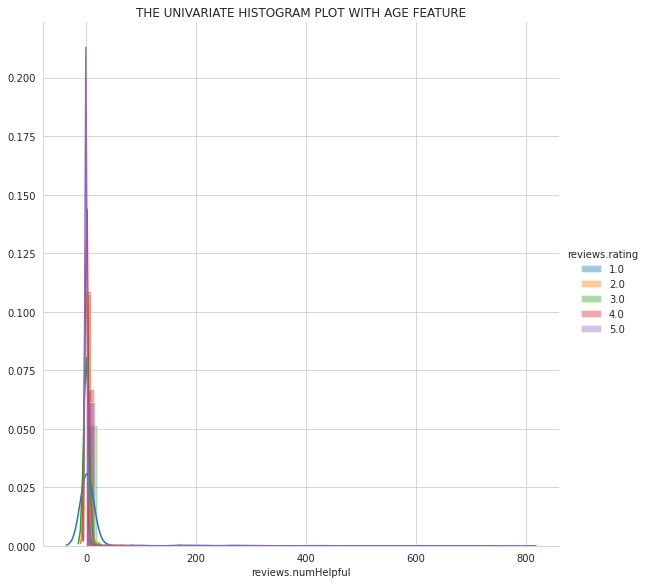

In [ ]:
sns.set_style("whitegrid")
sns.FacetGrid(data,hue="reviews.rating",size=8) \
.map(sns.distplot,"reviews.numHelpful") \
.add_legend()
plt.title("THE UNIVARIATE HISTOGRAM PLOT WITH AGE FEATURE")
plt.show()

In order to understand this better, we build another feature called y. y is given a value 1 for positive review( if the rating is >3) and y is given a value of 0 for negative review if rating is less than or equal to 3

In [ ]:
y=[]
for i in range(data.shape[0]):
  if data.iloc[i]["reviews.rating"]>3:
    y.append(1)
  else:
    y.append(0)
data["y"]=y

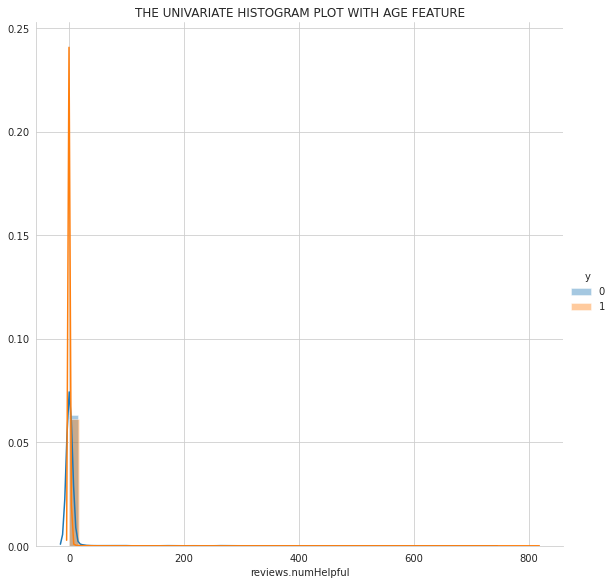

In [ ]:
sns.set_style("whitegrid")
sns.FacetGrid(data,hue="y",size=8) \
.map(sns.distplot,"reviews.numHelpful") \
.add_legend()
plt.title("THE UNIVARIATE HISTOGRAM PLOT WITH AGE FEATURE")
plt.show()

**OBSERVATION:** This feature has some effect. For example, if the helpful numerator is very high, then most likely, the review is positive. Or in other words, for most of the users the positive reviews of the product is something they find more helpful. 

### Role of feature "title"

Next feature to be considered is the title feature. As seen earlier, most of the reviews have a title. There are 5 reviews, which doesnot have a title. Lets look at some title, the corresponding reviews and the ratings

In [ ]:
ids=np.random.choice(range(data.shape[0]),10)
for idx in ids:
  print("TITLE: ",data.iloc[idx]["reviews.title"])
  print("REVIEW: ",data.iloc[idx]["reviews.text"])
  print("RATING: ",data.iloc[idx]["reviews.rating"])

TITLE:  great price for the product
REVIEW:  kids love it and i like it because it has child proof qualities.
RATING:  4.0
TITLE:  Great Buy!!!
REVIEW:  I would totally recommend purchasing Amazon Fire TV! I have enjoyed the simplicity of use and the app I was wanting Plex ! Best Buy had the best price for it so I purchased it from there local store!
RATING:  5.0
TITLE:  Pretty good
REVIEW:  Black Friday buy for the family. Good entertainment for the kiddos
RATING:  4.0
TITLE:  Gret Kindle
REVIEW:  Great Kindle, my wife had the originally one and this one is better in every way.
RATING:  5.0
TITLE:  Works really well!
REVIEW:  The Echo works really well for us. We stream music on it almost every day and my wife loves it. We weren't big Amazon users in the past so we don't use all of its functions but they just added a function that links it to our family calendar app and now we can add items to our grocery list just by asking Alexa.
RATING:  4.0
TITLE:  Great product for the price.
REV

Let's analyse the importance of some words in the title, in determing the rating of the product. We can use wordcloud for this

**Word cloud for positive titles**

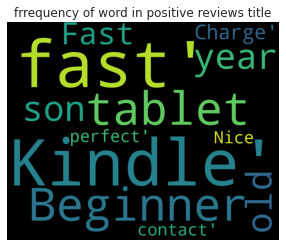

In [ ]:

text =data[data["reviews.rating"]>3.0]['reviews.title'].values
#https://stackoverflow.com/questions/43606339/generate-word-cloud-from-single-column-pandas-dataframe
wordcloud = WordCloud(width=1000,height=800).generate(str(text))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("frrequency of word in positive reviews title")
plt.show() 

**Wordcloud for negative titles**

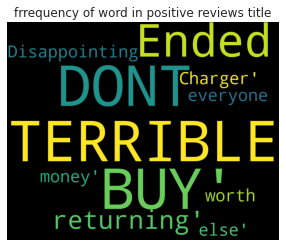

In [ ]:
#consider the positive reviews


text =data[data["reviews.rating"]<=3.0]['reviews.title'].values
#https://stackoverflow.com/questions/43606339/generate-word-cloud-from-single-column-pandas-dataframe
wordcloud = WordCloud(width=1000,height=800).generate(str(text))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("frrequency of word in positive reviews title")
plt.show() 

**OBSERVATION:** We can clearly see that the title of the review plays an imprtant role in finding the sentiment of that review. 

For example, here a title called "awesome tablet" indicate a positive review with a rating of above 3.0

Similarly, a title called "one star" indicate a negative review with a rating of below 3.0

From the wordcloud, we can see that word like perfect, fast, nice etc are contributing to positive reviews. words like terrible, dissappointing, returning etc are contributing to negative reviews


So, we can consider the title column also


### Role of user city and province


**OBSERVATION:** We ignore the user city and user province, beacuse they all conatin too many missing values. 

### Role of the user name in predicting the rating

This is a text fetaure which has the user name. Lets analyse this feature, by printing some sample names, corresponding reviews and ratings

In [ ]:
ids=np.random.choice(range(data.shape[0]),10)
for idx in ids:
  print("NAME: ",data.iloc[idx]["reviews.username"])
  print("REVIEW: ",data.iloc[idx]["reviews.text"])
  print("RATING: ",data.iloc[idx]["reviews.rating"])

NAME:  AverageJoe
REVIEW:  Ok tablet from amazon, added Google play to device for more apps. Google how to do this.
RATING:  3.0
NAME:  SpeakerFreak
REVIEW:  Great little tablet, easy to use for kids. Wish the battery was bigger. Overall not a bad purchase.
RATING:  4.0
NAME:  ReplacedIphone
REVIEW:  It sits there all day at the ready. You can just ask it a question like math or unit conversion. You can ask about the weather. Ask it to play music; turn the volume up or down, skip, or restart.
RATING:  5.0
NAME:  alopezmx13
REVIEW:  Great tablet. My kids love it. Great for the prices.
RATING:  4.0
NAME:  skidmark
REVIEW:  works great once I figured it out. Books are easy to download.
RATING:  3.0
NAME:  Great4me
REVIEW:  Ok, but sometimes alexa begin speaking without being asked, and sometimes light spins around when asked alexa a question without any answer.
RATING:  3.0
NAME:  RedLantern
REVIEW:  Awesome product!! I buy them regularly!!! If looking for a good device buy this one
RATIN

**OBSERVATION:** Clearly, the user name doesnot indicate anything about the reviews. So thiss feature is unnecessarily adding the complexity without giving any useful information about the output. So we discard this feature also.

### Analysing the feature reviews.text

This is a text feature. So lets analyse some reviews and the corresponding ratings

In [ ]:
ids=np.random.choice(range(data.shape[0]),10)
for idx in ids:
  
  print("REVIEW: ",data.iloc[idx]["reviews.text"])
  print("RATING: ",data.iloc[idx]["reviews.rating"])

REVIEW:  My daughter absolutely love her tablet and I love it to for her. It's very kids friendly
RATING:  5.0
REVIEW:  Good starter tech equipment for the 8 year old..I am happy with the purchase
RATING:  4.0
REVIEW:  My kids love their amazon kindles! They can take them anywhere and play on them! Great battery life!
RATING:  5.0
REVIEW:  Got it on sale for $34.99 so I can say I got more than my moneys worth so far so good.
RATING:  5.0
REVIEW:  I bought this for my toddler to keep her busy on road trips or at appointments and she wasn't too fond of it. It's kinda slow and limited to what you can do. One feature I did like is that you can set a profile for kids and they'll only be able to use apps that you designate for them to use.
RATING:  3.0
REVIEW:  Easy to navigate, relatively durable, sweet little tablet!
RATING:  5.0
REVIEW:  I'm not very tech savvy but we're getting there! I think this is a great price for a tablet that can do so much!
RATING:  5.0
REVIEW:  Love it! Best e re

**Word Cloud for Positive Reviews**
We consider the reviews with rating greater than 3. This conatins positive reviews.

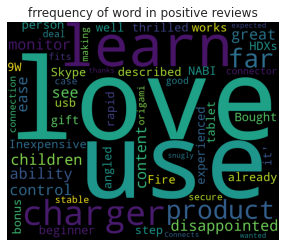

In [ ]:
#consider the positive reviews


text =data[data["reviews.rating"]>3.0]['reviews.text'].values
#https://stackoverflow.com/questions/43606339/generate-word-cloud-from-single-column-pandas-dataframe
wordcloud = WordCloud(width=1000,height=800).generate(str(text))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("frrequency of word in positive reviews")
plt.show() 

**Word Cloud for Negative Reviews**
We consider the reviews with rating less than or equal to 3. This conatins negative reviews.

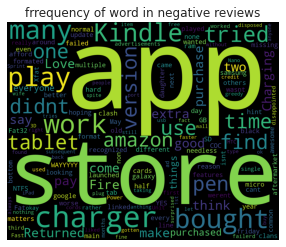

In [ ]:

text =data[data["reviews.rating"]<=3.0]['reviews.text'].values
#https://stackoverflow.com/questions/43606339/generate-word-cloud-from-single-column-pandas-dataframe
wordcloud = WordCloud(width=1000,height=800).generate(str(text))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("frrequency of word in negative reviews")
plt.show() 

**OBSERVATION:** We can see that some words in the reviews can hep in predicting the rating.

For example, words like great, amazing, good etc is most likely to be present in a positive review. Similarly word like waste, bad etc is mostly occuring in negative reviews. 

Let's analyse this much more deeper by plotting the wordcloud. This will help us to understand the most frequent words present in positive and negative review.



**OBSERVATION FROM WORDCLOUD:** From this, we can see that the word like great, thrilled, love, excellent etc are some frequent words occuring in positive reviews. Also words like returned,missing, failed etc are  present in negative reviews. We can conclude that review.text and revew.title are the most important features that can be used

### Analyse the feature "reviews.rating" 

This is the feature, we need to predict. Let's analyse the disrtibution of this feature in our data

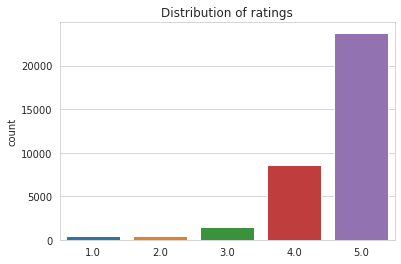

In [ ]:
sns.countplot(data["reviews.rating"].values)
plt.title("Distribution of ratings")
plt.show()

We can see that the data is heavily imbalanced. Most of the reviews has a rating of 4 and 5. Reviews with rating 1 and 2 are very low

Our aim is to predict the sentiment of a review. So we use the feature "y" which will have a value of 1 for positive review and has a value of 0 for negative reviews

Ratings above 3 are surely positive reviews

Ratings below 3 are surely negative reviews

For reviews having rating=3, they are neutral. So we need to either drop these entries or accomdate them as either positive or negative. 


Let's check the number of reviews with rating =3

In [ ]:
text =data[data["reviews.rating"]==3.0]['reviews.text'].values
print("there are {} number of reviews with rating =3 ".format(text.shape[0]))

there are 1499 number of reviews with rating =3 


So we cannot just drop these rows. 

In [ ]:
# Consider some reviews with rating =3

text =data[data["reviews.rating"]==3.0]['reviews.text'].values
a=np.random.choice(range(text.shape[0]),10)
for each in a:
  print(text[each])


It is ok to be a "android" tablet with such a low price. But the display is not good as they described.It hurts my eyes after long use.
Not the greatest for productivity but it's very good at entertaining kids at a cheap price.
I enjoy all the features on the Fire 7 tablet!!!!!
Kindle Fire is a decent tablet. The only turn off is the way Amazon has massacred the Android OS and makes it incompatible with chromecast most of the time. It's a great tablet for reading and saving media on the go. Other than the OS, Kindle Fire is a decent buy.
Its ok for the price if willing to deal with the ads and cant download certain apps.
worth it to spend the extra 50 dollars and get the box w game control
Its light weight, i do not care for the amazon app store..Android is so much better..I cannot get all the app I need from amazon..the amazon Kindle is a nice size and light weight..
the amount i paid for the tablet is worth it on sale.
Average tablet for general use. I still like Apple better!
volume

This reviews are more to a negative review. We can see from the box plot of ratings also, that the product recommendation =True when review is greater than 3. When review is less than equal to 3, the product recommendation is mostly no. So we consider this as negative reviews. Now let's analyse the frequency of positive and negative reviews

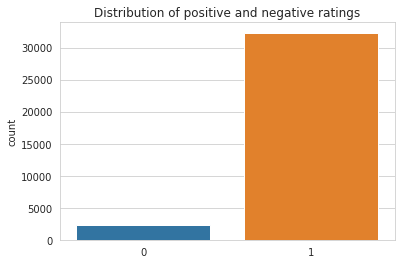

In [ ]:
sns.countplot(data["y"].values)
plt.title("Distribution of positive and negative ratings")
plt.show()

##CONCLUSIONS FROM EDA:
1. The features which we conisder are "review.title",
 "Review.text" and "doRecommed" and "dates"

2. We combine both title column and text column as a single column for easing the analysis. However, we can give more weightage to the title if needeed, beause titles are short and conatins very useful information.

3. There are some rows where title is empty. In those cases, we just conisder it as an empty string and consider the review.text alone

4. There are three possible values we can give for "doRecommend". True, False and nan. We can treat this as a categorical variable with three categories

5. The output varibale we consider is "y" instaed of "reviews.rating". y is 0 for negative reviews and 1 for positive reviews

6. There is heavy class imbalance in the data

### Preprocessing of the text data

First we need to combine the reviews.text and text into one column- reviews. NOw here we give more weightage to title, beause it contains more useful information.

So every entry in the reviews column will be title+title+title+review.text

In [8]:
#creating the review column
review=[]
for id in tqdm(range(data.shape[0])):
  try:
    s=3*(data.iloc[id]["reviews.title"]+" ") + data.iloc[id]["reviews.text"]
  except:
    s=data.iloc[id]["reviews.text"]
    
  review.append(s)


data["reviews"]=np.array(review)

100%|██████████| 34660/34660 [00:11<00:00, 3007.72it/s]


In [9]:
data["reviews"]

0        Kindle Kindle Kindle This product so far has n...
1        very fast very fast very fast great for beginn...
2        Beginner tablet for our 9 year old son. Beginn...
3        Good!!! Good!!! Good!!! I've had my Fire HD 8 ...
4        Fantastic Tablet for kids Fantastic Tablet for...
                               ...                        
34655    Not appreciably faster than any other 1.8A cha...
34656    Should be included Should be included Should b...
34657    Disappointing Charger Disappointing Charger Di...
34658    Not worth the money Not worth the money Not wo...
34659    as with everyone else as with everyone else as...
Name: reviews, Length: 34660, dtype: object

Analyze the length of reviews

In [10]:
length=[]
for l in data["reviews"].values:
  length.append(len(l.split()))
length=np.array(length)
print("mean length is ",np.mean(length))
print("80th percentile of length is ",np.percentile(length,80))
print("90th percentile of length is ",np.percentile(length,90))
print("99th percentile of length is ",np.percentile(length,99))
print("maximum value for length is ",np.max(length))

mean length is  40.94192152336988
80th percentile of length is  53.0
90th percentile of length is  72.0
99th percentile of length is  175.0
maximum value for length is  1888


Most of the reviews has a length below 100

## Text Preprocessing

In [ ]:
#convert all the words into lowercase
lines=data["reviews"].values
lines=[l.lower() for l in lines]
for i in range(10):
  print(lines[i])


kindle kindle kindle this product so far has not disappointed. my children love to use it and i like the ability to monitor control what content they see with ease.
very fast very fast very fast great for beginner or experienced person. bought as a gift and she loves it
beginner tablet for our 9 year old son. beginner tablet for our 9 year old son. beginner tablet for our 9 year old son. inexpensive tablet for him to use and learn on, step up from the nabi. he was thrilled with it, learn how to skype on it already...
good!!! good!!! good!!! i've had my fire hd 8 two weeks now and i love it. this tablet is a great value.we are prime members and that is where this tablet shines. i love being able to easily access all of the prime content as well as movies you can download and watch laterthis has a 1280/800 screen which has some really nice look to it its nice and crisp and very bright infact it is brighter then the ipad pro costing $900 base model. the build on this fire is insanely awes

In [ ]:
#considering the set of english stopword available in nltk
#we remove "no" and "not" from this set. because the removal of these stopwords from the review might change the meaning of the review
stop=set(stopwords.words("english"))-{"not","no"}  

In [ ]:
#Now we need to expand the contractions like won't, can't, don't etc.
#https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"i'd": "i had / i would",
"i'd've": "i would have",
"i'll": "i shall / I will",
"i'll've": "i shall have / i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}


In [ ]:
#expanding the contaractions
for idx in tqdm(range(len(lines))):
  list_of_words=lines[idx].split(" ")
  
  sentence=""
  for i in list_of_words:
    
    if len(i)>=2:
      #expanding the contractions
      if i in list(contractions.keys()):
        wrd=contractions[i]
      else:
        wrd=i
      
      sentence+=wrd+" "
    else:
      continue
  lines[idx]=sentence
  

100%|██████████| 34660/34660 [00:04<00:00, 8357.11it/s]


In [ ]:
'''
in sentment analysis stop words doesnot add much information in the sentence.
 So they are removed. However words like no and not are exclused from the stopwords'''

for idx in tqdm(range(len(lines))):
  list_of_words=lines[idx].split(" ")
  
  sentence=""
  for i in list_of_words:
    
    if i not in stop:
      sentence+=i+" "
    else:
      continue
  lines[idx]=sentence
  

100%|██████████| 34660/34660 [00:00<00:00, 76277.64it/s]


In [ ]:
#remove all the special charcters and digits from the review
lines=[re.sub("[^a-z]"," ",l) for l in lines]

In [ ]:
#remove additional space if any

lines=[re.sub("\s\s+"," ",l) for l in lines]

In [ ]:
#remove all word having length less than 2
lines=[re.sub(r'\b\w{1,2}\b',"",l) for l in tqdm(lines)]

100%|██████████| 34660/34660 [00:00<00:00, 146853.54it/s]


In [ ]:
for i in range(10):
  print(lines[i])
  print("*"*50) 

kindle kindle kindle product far not disappointed children love use like ability monitor control content see ease 
**************************************************
fast fast fast great beginner experienced person bought gift loves 
**************************************************
beginner tablet year old son beginner tablet year old son beginner tablet year old son inexpensive tablet use learn  step nabi thrilled  learn skype already 
**************************************************
good good good fire  two weeks love  tablet great value  prime members tablet shines love able easily access prime content well movies download watch laterthis screen really nice look nice crisp bright infact brighter ipad pro costing base model build fire insanely awesome running  thick smooth glossy feel back really amazing hold like futuristic tab  hands 
**************************************************
fantastic tablet kids fantastic tablet kids fantastic tablet kids bought grand daughter comes 

In [ ]:
#constructing the dataframe and storing it to the disk
data["reviews"]=lines

### Analyse the frequency of words in negative and positive reviews

In [ ]:
data1=data[["dates","reviews","reviews.doRecommend","y"]]
data1


,dates,reviews,reviews.doRecommend,y
0,2017-06-07 09:04:00,kindle kindle kindle product far not disappoin...,True,1
1,2017-06-07 09:04:00,fast fast fast great beginner experienced pers...,True,1
2,2017-06-07 09:04:00,beginner tablet year old son beginner tablet y...,True,1
3,2017-06-07 09:04:00,good good good fire two weeks love tablet gr...,True,1
4,2017-06-07 09:04:00,fantastic tablet kids fantastic tablet kids fa...,True,1
...,...,...,...,...
34655,2015-08-29 00:00:00,not appreciably faster charger not appreciabl...,NaN,0
34656,2015-09-02 00:00:00,included included included amazon include char...,NaN,0
34657,2015-09-04 00:00:00,disappointing charger disappointing charger di...,NaN,0
34658,2015-09-01 00:00:00,not worth money not worth money not worth mone...,NaN,0


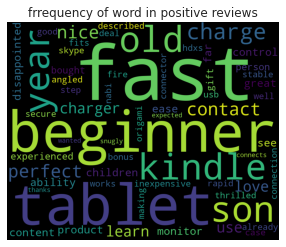

In [ ]:
#consider the positive reviews


text = data1[data1["y"]==1]['reviews'].values
#https://stackoverflow.com/questions/43606339/generate-word-cloud-from-single-column-pandas-dataframe
wordcloud = WordCloud(width=1000,height=800).generate(str(text))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("frrequency of word in positive reviews")
plt.show() 

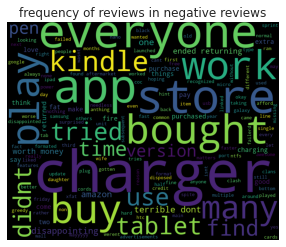

In [ ]:
#consider the negative reviews

text = data1[data1["y"]==0]["reviews"].values

wordcloud = WordCloud(width=1000,height=800).generate(str(text))
plt.imshow(wordcloud)
plt.title("frequency of reviews in negative reviews")
plt.axis("off")
plt.show()  

In [ ]:
data1.to_csv("df_preprocessed")

Now we will remove the nan values, from the dataset



In [ ]:
df=pd.read_csv("df_preprocessed")

In [ ]:
df.isnull().sum()

Unnamed: 0               0
dates                    0
reviews                  0
reviews.doRecommend    594
y                        0
dtype: int64

In [ ]:
df.dropna(inplace=True)
df.isnull().sum()

Unnamed: 0             0
dates                  0
reviews                0
reviews.doRecommend    0
y                      0
dtype: int64

We removed all the null or nan values from the datset

**Polarity using TextBlob**

We will use the textblob library to get the polarity of reviews. textblob.polarity will return the polarity of the review as a value in the range of [-1,1]. A negative polarity will get a polarity value close to -1 and a positive review will get a value near to 1

In [ ]:
import textblob
from textblob import TextBlob
df["polarity"]=df["reviews"].apply(lambda x: TextBlob(x).sentiment.polarity)

Now lets print some reviews and the polarity

In [ ]:
index=np.random.choice(range(df.shape[0]),10)
for i in index:
  print("REVIEW: ",df.iloc[i]["reviews"])
  print("POLARITY: ",df.iloc[i]["polarity"])
  print("*"*100)

REVIEW:     want tap make use amazon  alexa voice services dont get one tap fine enough bluetooth speaker wireless music need touch button voice services renders far less valuable 
POLARITY:  0.08750000000000002
****************************************************************************************************
REVIEW:  great speaker cloud connection great speaker cloud connection great speaker cloud connection use playing music alarms control smart home devices great see everything works flawless 
POLARITY:  0.7357142857142858
****************************************************************************************************
REVIEW:  great family great family great family son use tablet everyday times morning night theres much  
POLARITY:  0.4800000000000001
****************************************************************************************************
REVIEW:   streaming device  streaming device  streaming device bought fire wanted get vue playstation not stream roku first not 

We can see that the polarity value of negative reviews is negative itself. And for positive reviews, this value is greater than 0. So we can use this as another feature for finding the sentiment of reviews

In [ ]:
length=[]
for l in df["reviews"].values:
  length.append(len(l))
length=np.array(length)
print("mean length is ",np.mean(length))
print("80th percentile of length is ",np.percentile(length,80))
print("90th percentile of length is ",np.percentile(length,90))
print("99th percentile of length is ",np.percentile(length,99))
print("maximum value for length is ",np.max(length))

mean length is  147.74279340104502
80th percentile of length is  189.0
90th percentile of length is  249.0
99th percentile of length is  561.0
maximum value for length is  5132


Now lets consider only those reviews, whose length is less tha 600. As we saw earlier, most of the reviews has a length below 600. So we ignore all other reviews whose length is more than 600

In [ ]:

df_dash=df[df["reviews"].apply(lambda x: len(x)<=600)]

We also need to convert the "do recommend columm into 1 and 0

In [ ]:
df_dash["reviews.doRecommend"]=df_dash['reviews.doRecommend'].astype(int)


Finally we need to sort this dataframe using time

In [ ]:
df_dash=df_dash.sort_values(by="dates")
df_dash

,Unnamed: 0,dates,reviews,reviews.doRecommend,y,polarity
16016,16016,2017-03-04 10:47:59.786,great great great great kids play easy monitor...,1,1,0.588889
16009,16009,2017-03-04 10:47:59.786,not meet needs not meet needs not meet needs n...,0,0,-0.250000
16010,16010,2017-03-04 10:47:59.786,great kids great kids great kids easy little o...,1,1,0.574306
16011,16011,2017-03-04 10:47:59.786,kid loves kid loves kid loves great tablet ...,1,1,0.393519
16015,16015,2017-03-04 10:47:59.786,great computer great computer great computer ...,1,1,0.625000
...,...,...,...,...,...,...
29413,29413,2018-04-28 00:00:00.000,nice portable speaker alexa nice portable spea...,1,1,0.510000
29469,29469,2018-04-28 00:00:00.000,difficult figure difficult figure difficult fi...,0,0,-0.233333
29548,29548,2018-04-28 00:00:00.000,hands free hands free hands free echo not upda...,1,0,0.308333
29008,29008,2018-04-28 00:00:00.000,fun fun fun fun fun fun fun fun fun took bit t...,1,1,0.300000


In [ ]:
df_dash.to_csv("df_preprocessed_nw")
 